# FFT accuracy using (py)vkfft
The methodology follows http://www.fftw.org/accuracy/method.html:
* random values are generated with a uniform distribution between -0.5 and 0.5 (for both real and imaginary values)
* the comparison is made with long double precision calculations performed with (py)fftw
* the comparison is made using the norms: $L_n(y) = \left[\Sigma{\left|y\right|^n}\right]^{1/n}$ (n=1,2 or $\infty$)
* the reported average accuracy is $\frac{L_n(fft_{ref} - fft)}{L_n(fft_{ref})}$

Note that the observed differences between the OpenCL and CUDA backend of VkFFT are due to 
different sine and cosine functions used when `useLUT` is not specified. 
With `useLUT=1` these differences disappear, and may also not exist on different GPUs.

In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
# pyfftw supports long double accuracy
from pyfftw.interfaces.scipy_fft import fftn as fftwn, ifftn as ifftwn
from scipy.fft import fftn as fftsn, ifftn as ifftsn
from scipy import stats
from pyvkfft.fft import fftn as vkfftn, ifftn as ivkfftn
from pyvkfft.base import primes
from pyvkfft.version import __version__, vkfft_version

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("pyvkfft %s, VkFFT %s" % (__version__, vkfft_version()))

pyvkfft 2021.2.1, VkFFT 1.2.16


In [2]:
# Init pycuda
cuda_device_name = None
try:
    import pycuda.autoinit
    import pycuda.gpuarray as cua
    from pyvkfft.cuda import VkFFTApp as VkFFTAppcu
    has_pycuda = True
    cuda_device_name = pycuda.autoinit.device.name()
    print("Selected CUDA device: ", cuda_device_name)
    
    v_cufft_plan = []
    def fftncu(d):
        dcu = cua.to_gpu(d)
        plan = cu_fft.Plan(d.shape, d.dtype, d.dtype)
        cu_fft.fft(dcu, dcu, plan, scale=False)
        if cu_fft.cufft.cufftGetVersion() >= 10200:
            v_cufft_plan.append(plan)
        return dcu.get()
    
    def fftnvcu(d):
        dcu = cua.to_gpu(d)
        #return vkfftn(dcu).get()
        app = VkFFTAppcu(d.shape, d.dtype, useLUT=0)
        return app.fft(dcu).get()

    def fftnvculut(d):
        dcu = cua.to_gpu(d)
        app = VkFFTAppcu(d.shape, d.dtype, useLUT=1)
        return app.fft(dcu).get()

    try:
        import skcuda.fft as cu_fft
        has_cufft = True
        if cu_fft.cufft.cufftGetVersion() >= 10200:
            print("WARNING: cuFFT plans destruction is inhibited as a workaround for "
                  "an issue with CUDA>=11.0. See https://github.com/lebedov/scikit-cuda/issues/308\n"
                  "=> all cuFFT plans will be kept in GPU memory, effectively creating a memory leak "
                  "(this should be fine to run this notebook)")
    except:
        has_cufft = False
except:
    print("CUDA is not available")
    has_pycuda = False
    has_cufft = False


Selected CUDA device:  GeForce GTX 1080 Ti


/Users/vincent/dev/py38-env/lib/python3.8/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [3]:
# Init pyopencl
cl_device_name = None
try:
    import pyopencl as cl
    import pyopencl.array as cla
    import os
    from pyvkfft.opencl import VkFFTApp as VkFFTAppcl
    
    # Create some context on the first available GPU
    if 'PYOPENCL_CTX' in os.environ:
        ctx = cl.create_some_context()
    else:
        ctx = None
        # Find the first OpenCL GPU available and use it, unless
        for p in cl.get_platforms():
            for d in p.get_devices():
                if d.type & cl.device_type.GPU == 0:
                    continue
                cl_device_name = d.name
                print("Selected OpenCL device: ", d.name)
                ctx = cl.Context(devices=(d,))
                break
            if ctx is not None:
                break
    cq = cl.CommandQueue(ctx)

    def fftnvcl(d):
        dcl = cla.to_device(cq, d)
        #return vkfftn(d).get()
        app = VkFFTAppcl(d.shape, d.dtype, queue=cq, useLUT=0)
        return app.fft(dcl).get()

    def fftnvcllut(d):
        dcl = cla.to_device(cq, d)
        app = VkFFTAppcl(d.shape, d.dtype, queue=cq, useLUT=1)
        return app.fft(dcl).get()

    has_pyopencl = True
except:
    print("OpenCL is not available")
    has_pyopencl = False


Selected OpenCL device:  GeForce GTX 1080 Ti


In [4]:
def l1(a,b):
    return abs(a-b).sum() / abs(a).sum()

def l2(a,b):
    return np.sqrt((abs(a-b)**2).sum() / (abs(a)**2).sum())

def li(a,b):
    return abs(a-b).max() / abs(a).max()

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str


In [5]:
if has_pycuda:
    # CUDA
    device_name = "CUDA: " + cuda_device_name
else:
    # OpenCL
    device_name = "OpenCL: " + cl_device_name

fft_dic = {"fftw": fftwn}
if has_pycuda:
    fft_dic["vkfft-cuda"] = fftnvcu
    fft_dic["vkfft-cuda-LUT"] = fftnvculut
if has_cufft:
    fft_dic["cufft"] = fftncu
if has_pyopencl:
    fft_dic["vkfft-opencl"] = fftnvcl
    fft_dic["vkfft-opencl-LUT"] = fftnvcllut


## 1D, single precision

In [6]:
nmax = 2**18
d0 = np.random.uniform(-0.5, 0.5, nmax) + 1j * np.random.uniform(-0.5, 0.5, nmax)
d0ld = d0.astype(np.clongdouble)
d0s = d0.astype(np.complex64)



def accu_1d(n, fft_dic):
    rld = fftwn(d0ld[:n])
    res = {}
    for k,v in fft_dic.items():
        r = v(d0s[:n])
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res

# print(accu_1d(16, fft_dic))

vn, vl1, vl2, vli = [], {}, {}, {}

#print("%7s  %12s  %12s  %12s  %12s"%("N", "vkfft   ", "vkfft-LUT    ", "cufft   ", "fftw   "))
s = "%7s  %14s"%("N", "fftw   ")
r = accu_1d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %14s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) <= 3:
        r = accu_1d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        s = "%7d  %14e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N         fftw         vkfft-cuda  vkfft-cuda-LUT    vkfft-opencl  vkfft-opencl-LUT           cufft
      8    7.263771e-08      5.523626e-08      5.523626e-08      5.945792e-08      5.945792e-08      6.052943e-08
      9    7.840338e-08      1.371350e-07      6.343088e-08      9.064900e-08      6.983414e-08      6.405731e-08
     12    7.516921e-08      8.433461e-08      7.410827e-08      7.388705e-08      6.989580e-08      7.337561e-08
     16    8.101961e-08      6.242063e-08      6.019264e-08      7.373017e-08      6.001749e-08      8.908456e-08
     18    6.175550e-08      1.754842e-07      7.419411e-08      8.909762e-08      8.237450e-08      7.079644e-08
     24    6.993899e-08      1.025381e-07      7.513719e-08      8.591908e-08      6.319726e-08      7.563553e-08
     27    7.942158e-08      2.151588e-07      7.116520e-08      1.012057e-07      7.721327e-08      1.023881e-07
     32    7.387935e-08      8.300803e-08      6.530208e-08      1.018689e-07      7.149424e-08 

   1944    1.319696e-07      4.106166e-07      1.293405e-07      2.721405e-07      1.375272e-07      1.872647e-07
   2048    1.336500e-07      3.415962e-07      1.292276e-07      1.988269e-07      1.336248e-07      1.697849e-07
   2187    1.400458e-07      4.678876e-07      1.361585e-07      3.051977e-07      1.467038e-07      1.949846e-07
   2304    1.363820e-07      3.622071e-07      1.306761e-07      2.685680e-07      1.337033e-07      2.297494e-07
   2592    1.359927e-07      4.093780e-07      1.316336e-07      2.767176e-07      1.405220e-07      2.459681e-07
   2916    1.375100e-07      4.311559e-07      1.342910e-07      3.016380e-07      1.443536e-07      2.037163e-07
   3072    1.422800e-07      3.655183e-07      1.265219e-07      2.437514e-07      1.327545e-07      3.055269e-07
   3456    1.385825e-07      4.144103e-07      1.379258e-07      2.577017e-07      1.479383e-07      2.304053e-07
   3888    1.348101e-07      4.206996e-07      1.386118e-07      3.159327e-07      1.498

  41472    1.575495e-07      5.153308e-07      1.550744e-07      3.089172e-07      1.641179e-07      2.624806e-07
  46656    1.617520e-07      5.677759e-07      1.535146e-07      2.883151e-07      1.637283e-07      2.457910e-07
  49152    1.619208e-07      4.540122e-07      1.587916e-07      3.025511e-07      1.653674e-07      3.097620e-07
  52488    1.616002e-07      6.182451e-07      1.594822e-07      3.698639e-07      1.721906e-07      2.728193e-07
  55296    1.660781e-07      5.051813e-07      1.564601e-07      2.854239e-07      1.649443e-07      2.961294e-07
  59049    1.678452e-07      6.688783e-07      1.669849e-07      4.483535e-07      1.813387e-07      1.970949e-07
  62208    1.666835e-07      5.561944e-07      1.622198e-07      3.671733e-07      1.736598e-07      2.664137e-07
  65536    1.653461e-07      4.645599e-07      1.607963e-07      2.752663e-07      1.677644e-07      1.822224e-07
  69984    1.636945e-07      6.121831e-07      1.644182e-07      3.858042e-07      1.768

<IPython.core.display.Javascript object>


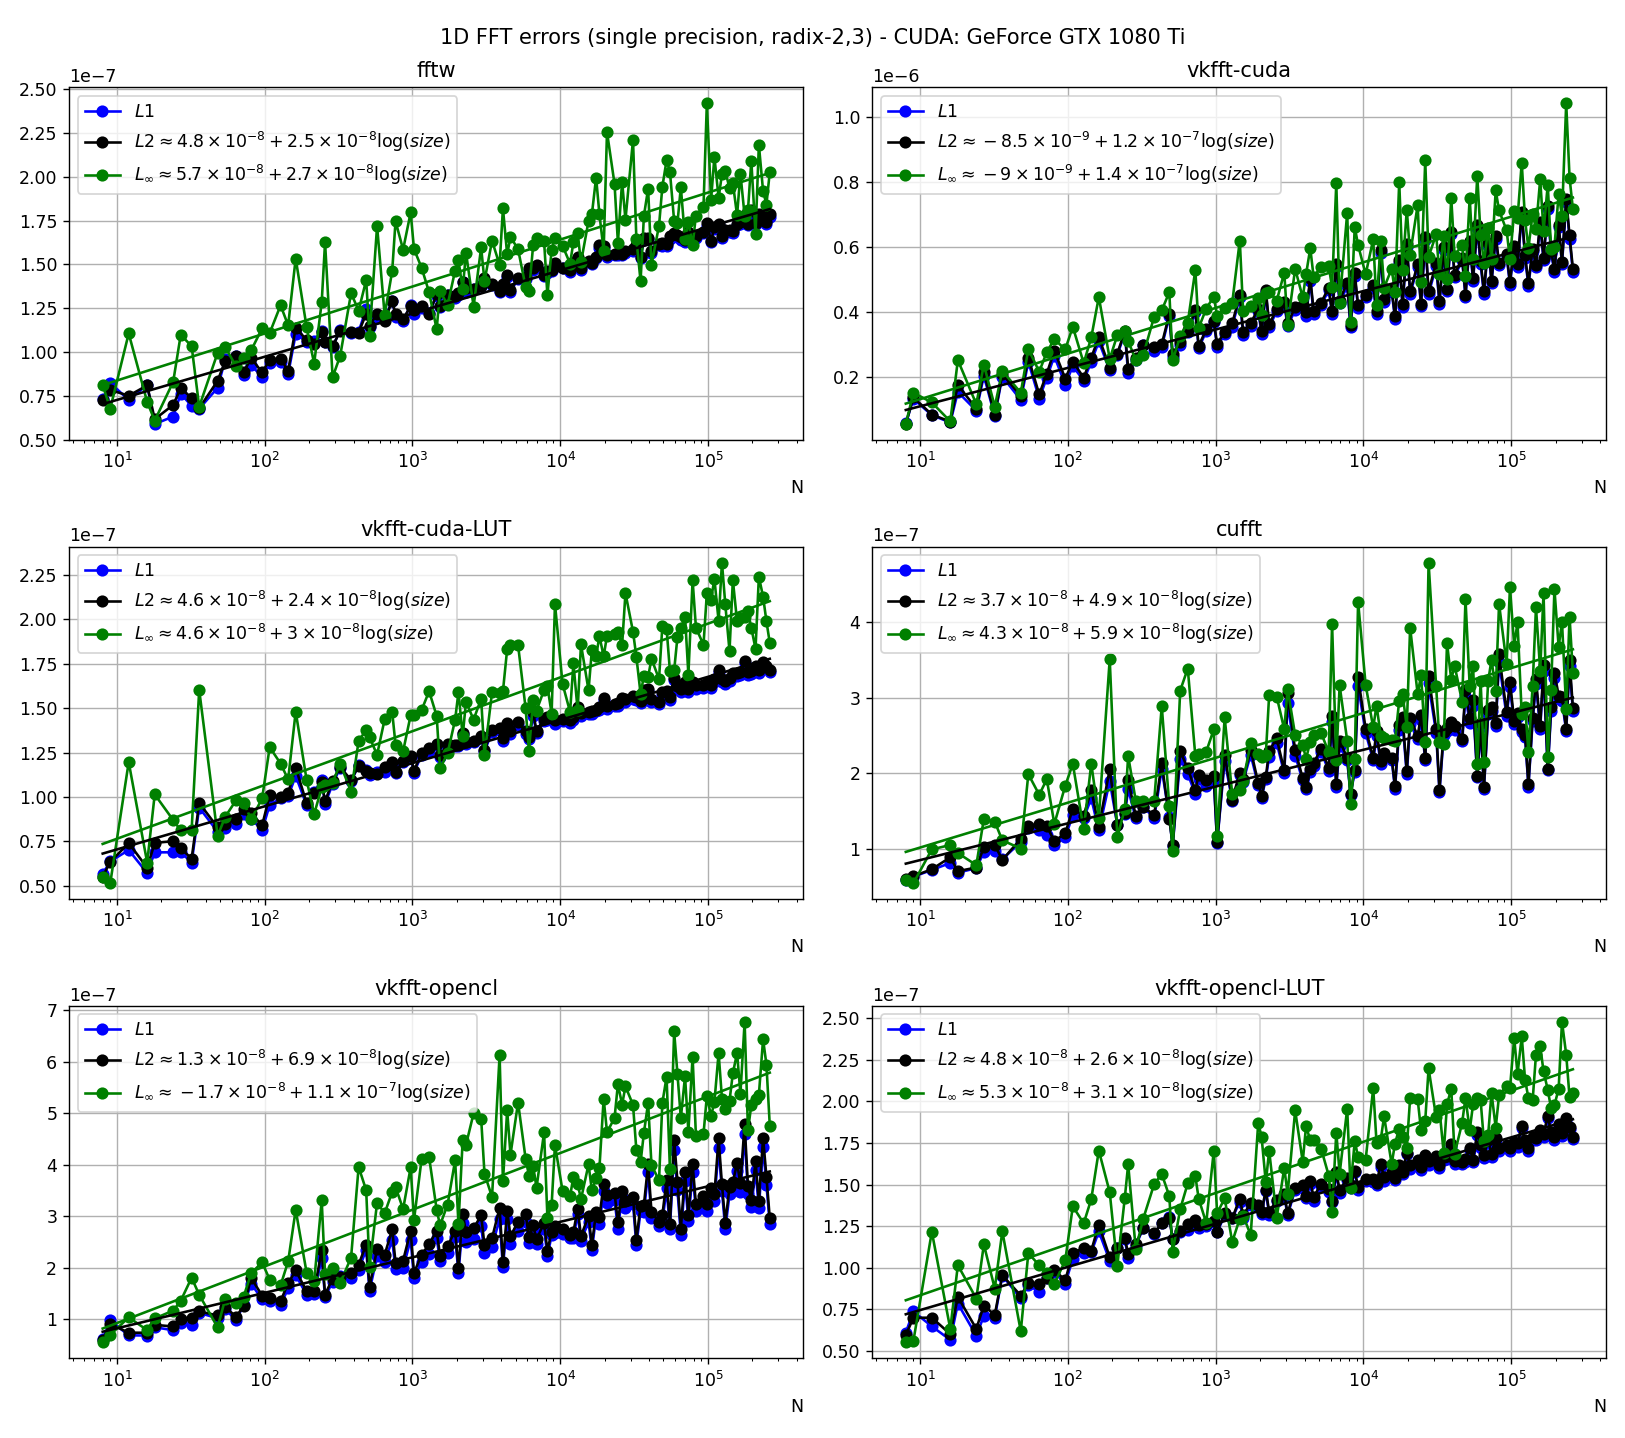

<IPython.core.display.Javascript object>


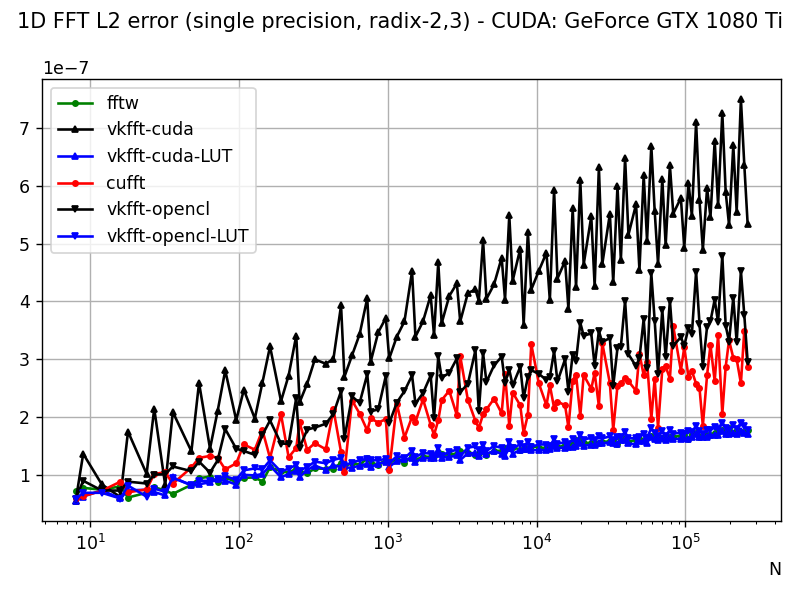

In [7]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("1D FFT errors (single precision, radix-2,3) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("1D FFT L2 error (single precision, radix-2,3) - " + device_name)
plt.xlabel("N", loc='right')
plt.grid(True)
plt.tight_layout()

## 1D, double precision

In [8]:
nmax = 2**18
d0 = np.random.uniform(-0.5, 0.5, nmax) + 1j * np.random.uniform(-0.5, 0.5, nmax)
d0ld = d0.astype(np.clongdouble)
d0d = d0.astype(np.complex128)



def accu_1d(n, fft_dic):
    rld = fftwn(d0ld[:n])
    res = {}
    for k,v in fft_dic.items():
        r = v(d0d[:n])
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res

# print(accu_1d(16, fft_dic))

vn, vl1, vl2, vli = [], {}, {}, {}

#print("%7s  %12s  %12s  %12s  %12s"%("N", "vkfft   ", "vkfft-LUT    ", "cufft   ", "fftw   "))
s = "%7s  %14s"%("N", "fftw   ")
r = accu_1d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %14s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) <= 3:
        r = accu_1d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        s = "%7d  %14e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N         fftw         vkfft-cuda  vkfft-cuda-LUT    vkfft-opencl  vkfft-opencl-LUT           cufft
      8    7.980008e-17      1.031068e-16      1.031068e-16      1.031078e-16      1.031078e-16      8.568740e-17
      9    1.525524e-16      1.283024e-16      1.283024e-16      1.438206e-16      1.438206e-16      1.049743e-16
     12    9.148945e-17      1.381970e-16      1.381970e-16      1.492033e-16      1.492033e-16      1.721749e-16
     16    1.232807e-16      8.331447e-17      8.331447e-17      8.182649e-17      8.182649e-17      8.810946e-17
     18    1.653154e-16      2.043927e-16      2.043927e-16      2.565370e-16      2.565370e-16      1.221850e-16
     24    1.024838e-16      2.052883e-16      2.052883e-16      1.947681e-16      1.947681e-16      1.802228e-16
     27    2.106423e-16      1.989204e-16      1.989204e-16      2.527263e-16      2.527263e-16      1.760101e-16
     32    1.317714e-16      1.339200e-16      1.339200e-16      1.367530e-16      1.367530e-16 

   1728    2.549683e-16      4.064884e-16      4.064884e-16      4.096940e-16      4.096940e-16      3.158742e-16
   1944    2.550899e-16      4.909945e-16      4.909945e-16      4.983217e-16      4.983217e-16      3.350208e-16
   2048    2.269422e-16      3.362905e-16      3.362905e-16      3.400430e-16      3.400430e-16      2.879746e-16
   2187    2.792903e-16      4.802293e-16      4.802293e-16      4.954908e-16      4.954908e-16      3.265947e-16
   2304    2.439942e-16      4.093269e-16      4.093269e-16      4.140331e-16      4.140331e-16      3.402440e-16
   2592    2.617020e-16      4.489412e-16      4.489412e-16      4.563777e-16      4.563777e-16      3.480696e-16
   2916    2.749105e-16      5.067390e-16      5.067390e-16      5.175818e-16      5.175818e-16      3.400493e-16
   3072    2.387498e-16      4.071787e-16      4.071787e-16      4.133284e-16      4.133284e-16      3.955980e-16
   3456    2.705773e-16      4.134001e-16      4.134001e-16      4.200003e-16      4.200

  39366    3.384117e-16      6.299198e-16      6.299198e-16      6.399870e-16      6.399870e-16      4.936945e-16
  41472    3.085268e-16      5.896880e-16      5.896880e-16      5.962276e-16      5.962276e-16      3.959578e-16
  46656    3.154038e-16      6.605684e-16      6.605684e-16      6.682855e-16      6.682855e-16      3.794827e-16
  49152    2.891622e-16      4.787207e-16      4.787207e-16      4.882047e-16      4.882047e-16      4.047930e-16
  52488    3.296105e-16      6.468936e-16      6.468936e-16      6.570493e-16      6.570493e-16      4.356515e-16
  55296    3.084608e-16      5.525527e-16      5.525527e-16      5.624396e-16      5.624396e-16      4.251225e-16
  59049    3.383006e-16      6.458427e-16      6.458427e-16      6.597822e-16      6.597822e-16      4.378367e-16
  62208    3.101636e-16      5.394267e-16      5.394267e-16      5.545204e-16      5.545204e-16      4.329085e-16
  65536    2.914640e-16      4.359163e-16      4.359163e-16      4.433324e-16      4.433

<IPython.core.display.Javascript object>


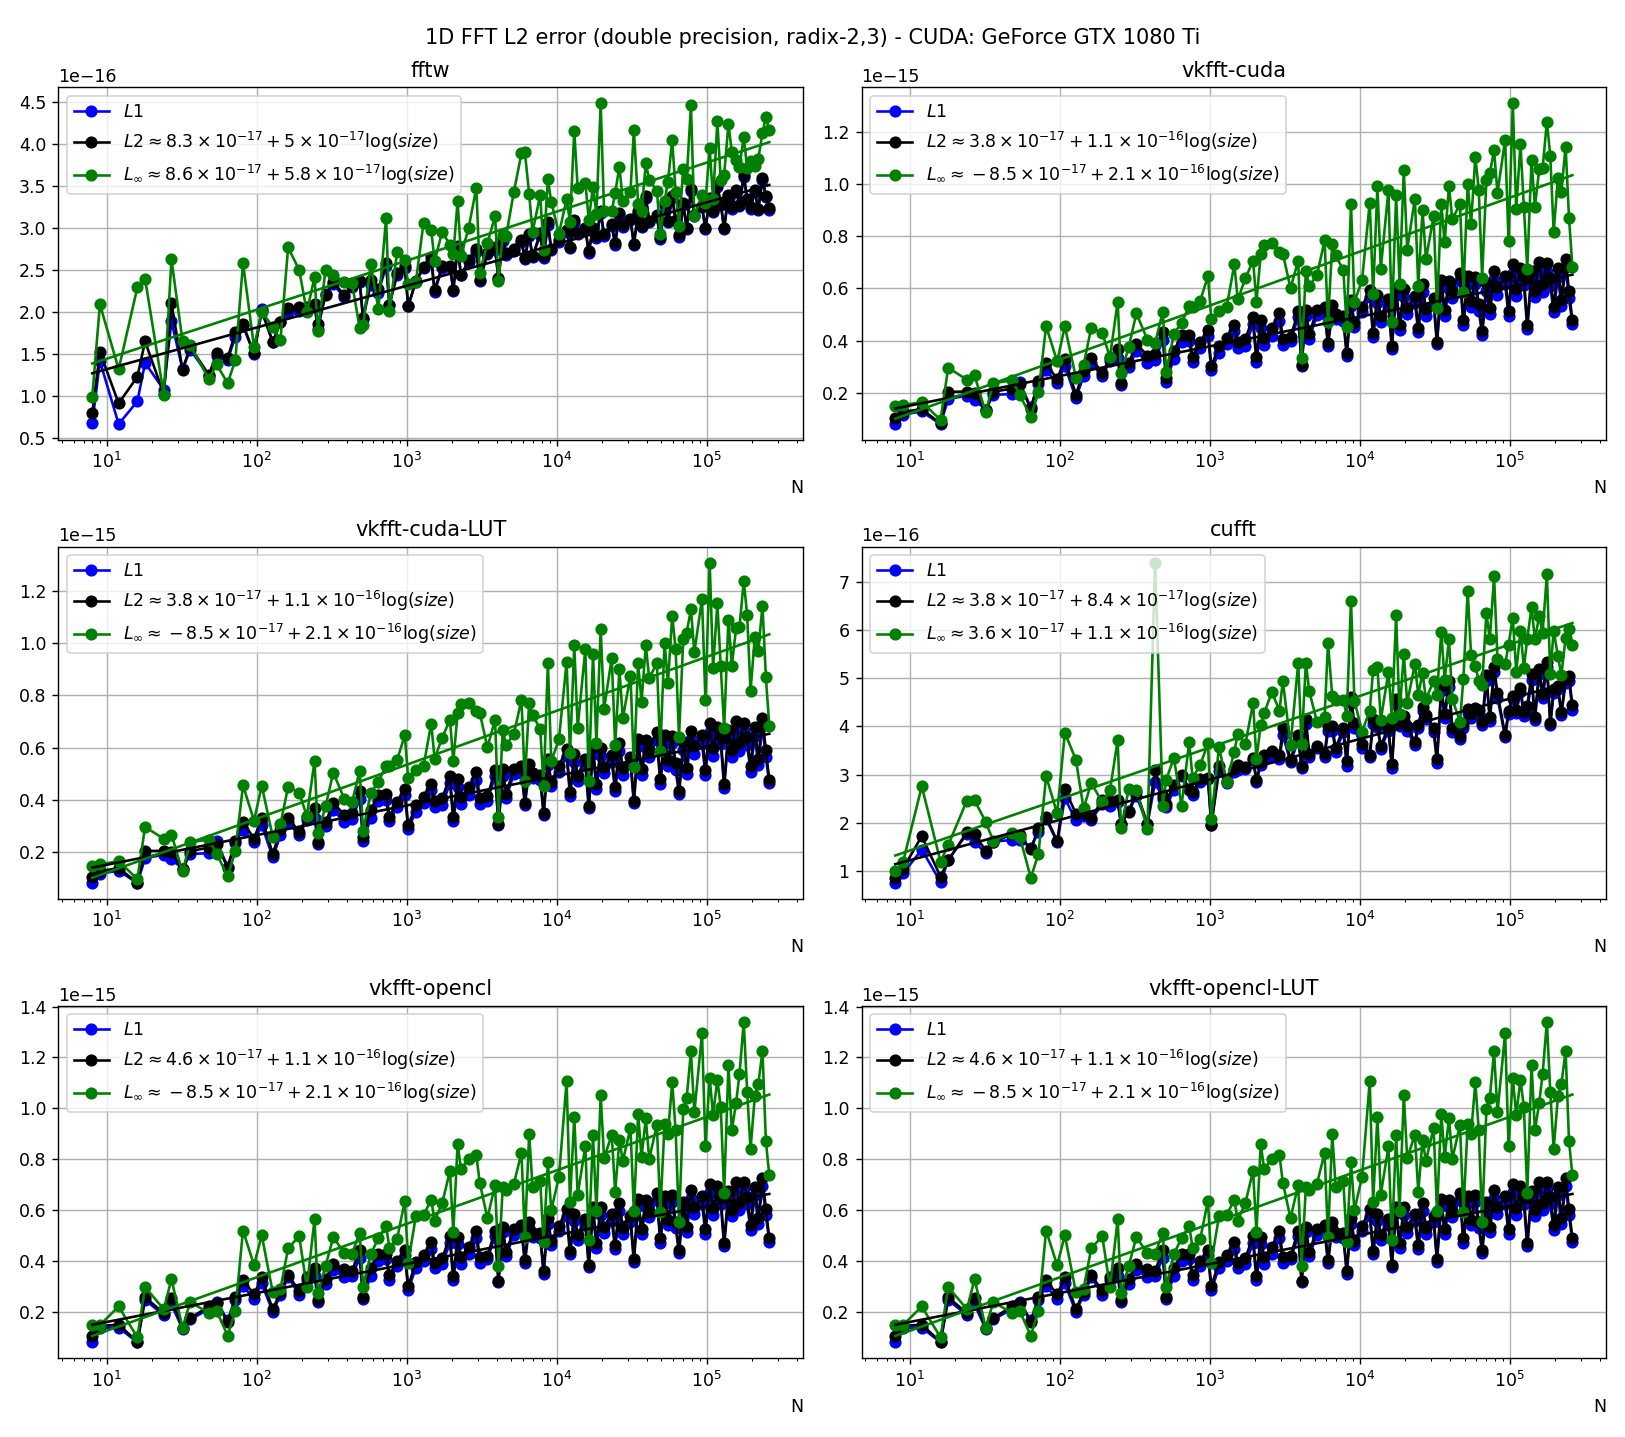

<IPython.core.display.Javascript object>


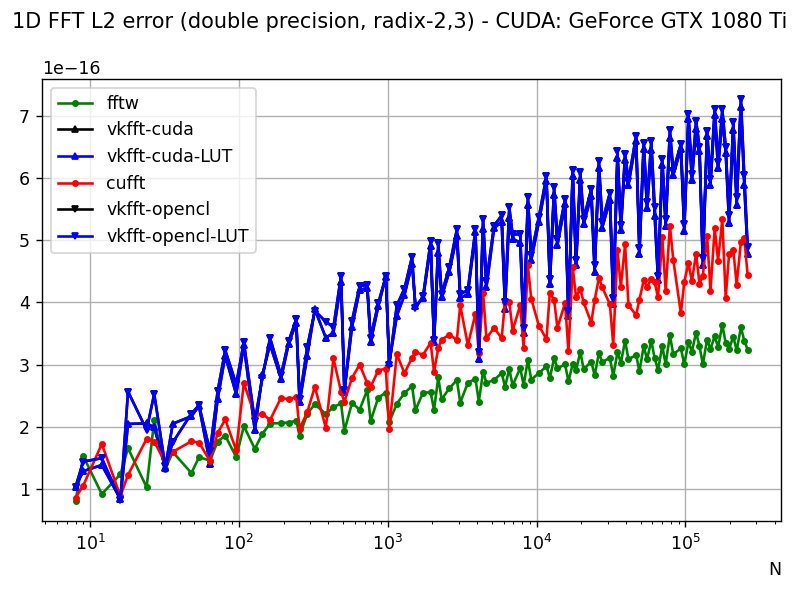

In [9]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("1D FFT L2 error (double precision, radix-2,3) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("1D FFT L2 error (double precision, radix-2,3) - " + device_name)
plt.xlabel("N", loc='right')
plt.grid(True)
plt.tight_layout()

## 2D, single precision

In [10]:
nmax = 512
d0 = np.random.uniform(-0.5, 0.5, (nmax, nmax)) + 1j * np.random.uniform(-0.5, 0.5, (nmax, nmax))
d0ld = d0.astype(np.clongdouble)
d0s = d0.astype(np.complex64)

def accu_2d(n, fft_dic):
    rld = fftwn(d0ld[:n,:n].copy())
    res = {}
    for k,v in fft_dic.items():
        r = v(d0s[:n,:n].copy())
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res


vn, vl1, vl2, vli = [], {}, {}, {}

s = "%7s  %14s"%("N", "fftw   ")
r = accu_2d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %14s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) <= 3:
        r = accu_2d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        
        s = "%7d  %14e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N         fftw         vkfft-cuda  vkfft-cuda-LUT    vkfft-opencl  vkfft-opencl-LUT           cufft
      8    7.767901e-08      6.932121e-08      6.951961e-08      7.747344e-08      7.747344e-08      7.810145e-08
      9    8.953289e-08      2.367880e-07      1.075355e-07      1.441275e-07      9.073205e-08      1.073607e-07
     12    8.073020e-08      1.306362e-07      8.951678e-08      1.139420e-07      8.939445e-08      1.054349e-07
     16    9.249661e-08      1.165685e-07      9.540429e-08      1.197603e-07      9.601119e-08      1.263834e-07
     18    1.179885e-07      2.898348e-07      1.132306e-07      1.449938e-07      1.186152e-07      1.237332e-07
     24    1.115609e-07      1.906997e-07      1.040077e-07      1.457010e-07      1.066844e-07      1.375763e-07
     27    1.246219e-07      3.347902e-07      1.190499e-07      1.694025e-07      1.274393e-07      1.531518e-07
     32    1.079066e-07      1.635711e-07      1.130802e-07      1.522559e-07      1.195146e-07 

<IPython.core.display.Javascript object>


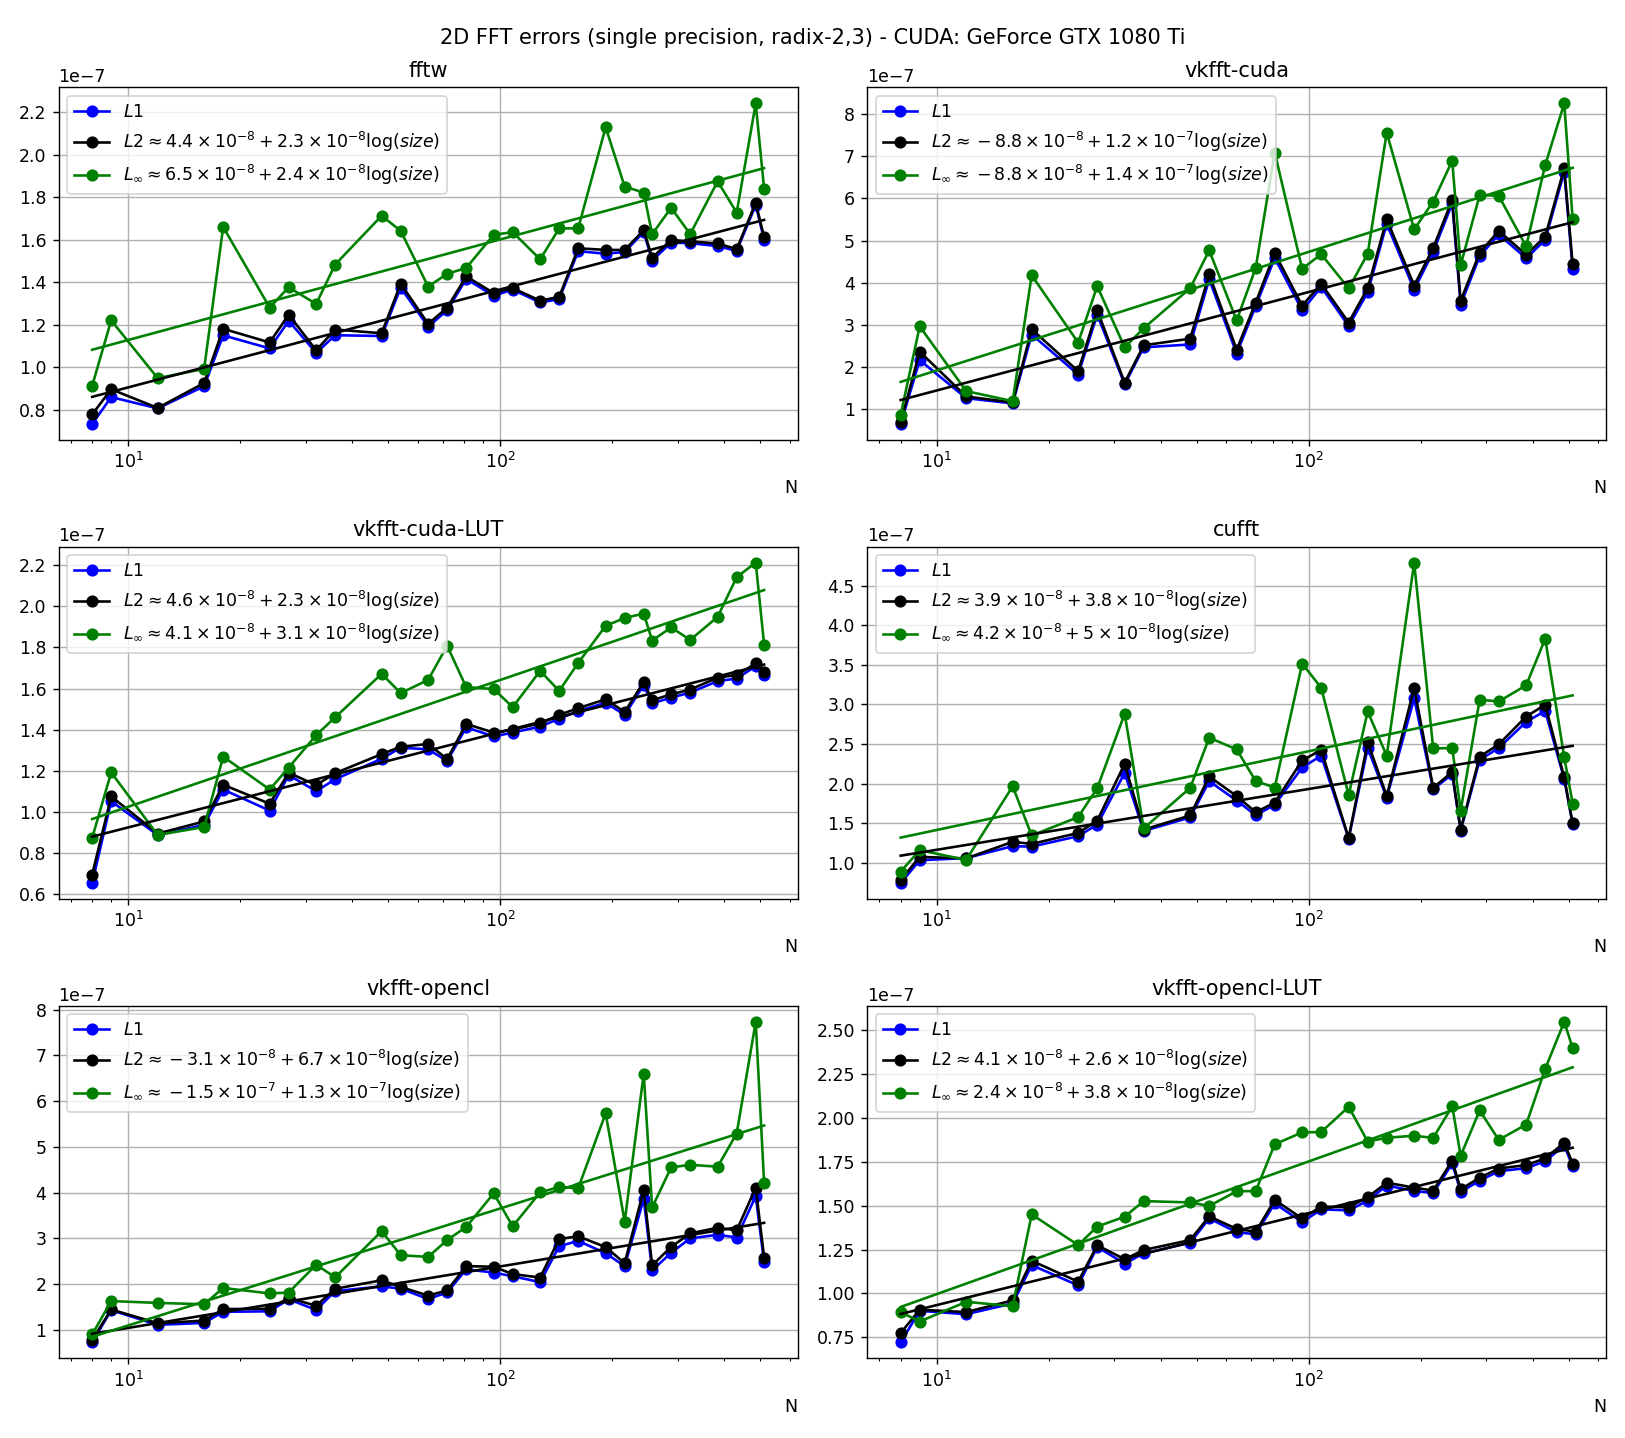

<IPython.core.display.Javascript object>


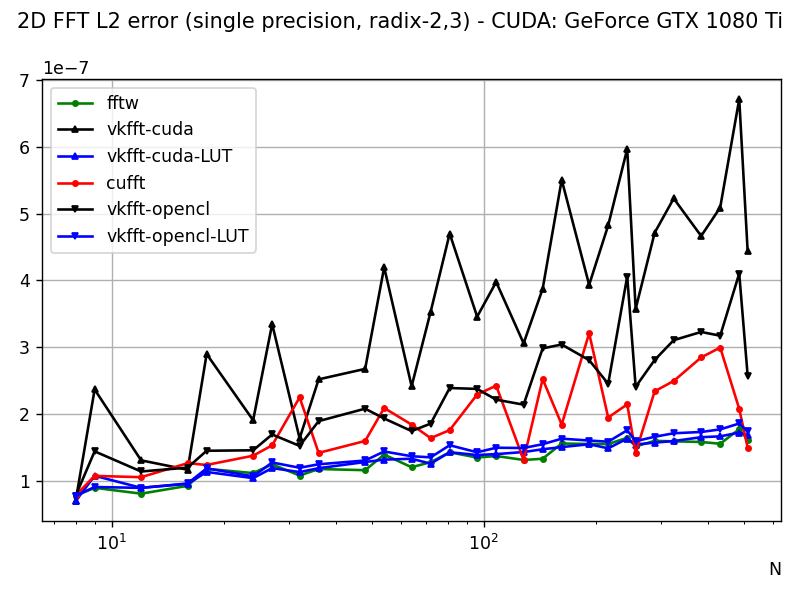

In [11]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("2D FFT errors (single precision, radix-2,3) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("2D FFT L2 error (single precision, radix-2,3) - " + device_name)
plt.grid(True)
plt.xlabel("N", loc='right')
plt.tight_layout()



# 1D, non-radix (Bluestein) transforms, single precision

In [12]:
nmax = 512
d0 = np.random.uniform(-0.5, 0.5, nmax) + 1j * np.random.uniform(-0.5, 0.5, nmax)
d0ld = d0.astype(np.clongdouble)
d0s = d0.astype(np.complex64)

def accu_1d(n, fft_dic):
    rld = fftwn(d0ld[:n])
    res = {}
    for k,v in fft_dic.items():
        r = v(d0s[:n])
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res

fft_dic = {"fftw": fftwn}
if has_pycuda:
    fft_dic["vkfft-cuda"] = fftnvcu
    fft_dic["vkfft-cuda-LUT"] = fftnvculut
    fft_dic["cufft"] = fftncu
if has_pyopencl:
    fft_dic["vkfft-opencl"] = fftnvcl
    fft_dic["vkfft-opencl-LUT"] = fftnvcllut


# print(accu_1d(16, fft_dic))

vn, vl1, vl2, vli = [], {}, {}, {}

#print("%7s  %12s  %12s  %12s  %12s"%("N", "vkfft   ", "vkfft-LUT    ", "cufft   ", "fftw   "))
s = "%7s  %16s"%("N", "fftw   ")
r = accu_1d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %16s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) >13:  # test only transforms with non-radix dimensions
        r = accu_1d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        s = "%7d  %16e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N           fftw           vkfft-cuda    vkfft-cuda-LUT      vkfft-opencl  vkfft-opencl-LUT             cufft
     17      6.762912e-08      2.363116e-07      1.396184e-07      1.479738e-07      1.559264e-07      6.761392e-08
     19      8.078921e-08      2.192701e-07      1.587186e-07      1.737957e-07      1.473702e-07      8.136379e-08
     23      7.879719e-08      2.378490e-07      1.621119e-07      1.670845e-07      1.479829e-07      6.212704e-08
     29      1.037757e-07      2.903124e-07      1.762551e-07      1.919426e-07      2.053393e-07      9.251689e-08
     31      8.446517e-08      2.369281e-07      1.685748e-07      1.672607e-07      1.590655e-07      8.828110e-08
     34      8.727644e-08      3.180161e-07      1.789909e-07      1.846009e-07      1.638012e-07      9.703046e-08
     37      1.360262e-07      2.587379e-07      1.441101e-07      1.610267e-07      1.489532e-07      7.656170e-08
     38      9.229448e-08      3.144399e-07      1.694955e-07      1.977

    103      1.861330e-07      3.664395e-07      1.879483e-07      1.895629e-07      2.060387e-07      1.316484e-07
    106      1.907124e-07      3.835273e-07      1.876935e-07      2.126511e-07      1.976319e-07      1.368074e-07
    107      2.049056e-07      3.798155e-07      1.878033e-07      2.235184e-07      1.955603e-07      1.388813e-07
    109      1.827296e-07      4.120949e-07      1.821349e-07      2.208527e-07      1.901625e-07      1.422558e-07
    111      1.399262e-07      3.531050e-07      1.842619e-07      2.243904e-07      2.076030e-07      1.394922e-07
    113      2.024012e-07      3.904887e-07      1.804612e-07      1.943413e-07      1.775361e-07      1.527830e-07
    114      1.005306e-07      3.970433e-07      1.856351e-07      2.087576e-07      2.103676e-07      1.587348e-07
    115      1.076414e-07      4.306776e-07      1.967142e-07      2.147419e-07      1.979339e-07      1.247197e-07
    116      1.042619e-07      3.517373e-07      1.730795e-07      2.080

    170      1.152188e-07      4.015174e-07      2.607904e-07      3.308658e-07      2.834492e-07      2.337557e-07
    171      1.031578e-07      4.451872e-07      2.650357e-07      3.390933e-07      2.846681e-07      1.234955e-07
    172      1.241242e-07      4.239201e-07      2.633673e-07      3.203663e-07      2.746878e-07      1.368547e-07
    173      1.994417e-07      5.028625e-07      2.258236e-07      2.778041e-07      2.416095e-07      2.317221e-07
    174      1.184383e-07      4.699909e-07      2.179787e-07      2.959766e-07      2.492135e-07      1.333556e-07
    177      1.924471e-07      5.722474e-07      1.969123e-07      2.697310e-07      2.180180e-07      1.679645e-07
    178      1.973183e-07      5.916404e-07      2.026617e-07      2.780141e-07      2.369744e-07      1.451099e-07
    179      2.196670e-07      6.273184e-07      2.175984e-07      2.845236e-07      2.337401e-07      2.293160e-07
    181      1.758108e-07      5.334425e-07      2.054933e-07      3.008

    227      2.115995e-07      4.565572e-07      2.163424e-07      2.476818e-07      2.207685e-07      2.318901e-07
    228      1.121574e-07      4.317541e-07      2.105587e-07      2.419244e-07      2.150381e-07      1.528717e-07
    229      2.116472e-07      4.385047e-07      2.168710e-07      2.478909e-07      2.350003e-07      2.329220e-07
    230      1.187455e-07      4.608888e-07      2.078493e-07      2.492069e-07      2.314793e-07      1.963352e-07
    232      1.094936e-07      4.813379e-07      2.497017e-07      2.504617e-07      2.412875e-07      1.376316e-07
    233      2.031500e-07      4.266601e-07      2.297854e-07      2.328854e-07      2.115117e-07      2.491087e-07
    235      1.856066e-07      4.574286e-07      2.182042e-07      2.335107e-07      2.388062e-07      1.233463e-07
    236      2.000710e-07      4.626678e-07      2.186167e-07      2.351741e-07      2.309662e-07      1.582527e-07
    237      2.056972e-07      4.759478e-07      2.378814e-07      2.491

    283      2.233124e-07      5.809991e-07      2.464881e-07      3.425213e-07      2.732011e-07      3.918994e-07
    284      1.759312e-07      5.888131e-07      2.456236e-07      3.553075e-07      2.757953e-07      1.426046e-07
    285      1.187152e-07      5.344806e-07      2.421073e-07      2.868711e-07      2.462899e-07      1.574987e-07
    287      1.689193e-07      5.342975e-07      2.213128e-07      2.854837e-07      2.301494e-07      1.285989e-07
    289      1.132064e-07      5.392090e-07      2.566275e-07      3.302581e-07      2.757286e-07      1.195234e-07
    290      1.246444e-07      5.480279e-07      2.524990e-07      3.143255e-07      2.580993e-07      1.569050e-07
    291      1.769903e-07      5.371249e-07      2.444607e-07      3.079422e-07      2.640421e-07      1.552554e-07
    292      1.608634e-07      5.261954e-07      2.504018e-07      3.288102e-07      2.709020e-07      1.603598e-07
    293      2.214015e-07      5.302465e-07      2.398549e-07      3.263

    337      2.206503e-07      6.399129e-07      2.251373e-07      3.517038e-07      2.491032e-07      3.930216e-07
    339      2.120640e-07      4.769936e-07      2.708358e-07      3.641924e-07      2.920267e-07      1.640633e-07
    340      1.172106e-07      4.620717e-07      2.637512e-07      3.593968e-07      3.010746e-07      2.303037e-07
    341      1.243749e-07      5.180960e-07      2.528382e-07      3.637273e-07      2.699213e-07      1.661213e-07
    342      1.161230e-07      5.185914e-07      2.575766e-07      3.835174e-07      2.940103e-07      1.412942e-07
    344      1.245362e-07      5.335524e-07      2.257577e-07      3.302792e-07      2.580721e-07      1.307789e-07
    345      1.156862e-07      5.484634e-07      2.283463e-07      3.352187e-07      2.516166e-07      2.121689e-07
    346      2.098774e-07      5.570280e-07      2.414983e-07      3.303094e-07      2.593990e-07      1.809746e-07
    347      2.119897e-07      5.612922e-07      2.381005e-07      3.133

    391      1.234031e-07      5.176278e-07      2.111775e-07      2.404816e-07      2.249271e-07      1.194722e-07
    393      2.167121e-07      5.112536e-07      2.177376e-07      2.346695e-07      2.238076e-07      1.908055e-07
    394      2.156230e-07      4.982571e-07      2.221624e-07      2.357527e-07      2.372792e-07      2.010277e-07
    395      1.987180e-07      5.236080e-07      2.169644e-07      2.399708e-07      2.204489e-07      2.108682e-07
    397      2.385111e-07      5.131825e-07      2.041022e-07      2.431453e-07      2.162526e-07      4.153937e-07
    398      2.082810e-07      5.024075e-07      2.187086e-07      2.277232e-07      2.190968e-07      2.042172e-07
    399      1.217757e-07      5.237680e-07      2.186126e-07      2.354798e-07      2.256346e-07      2.763891e-07
    401      2.085676e-07      5.030740e-07      2.117310e-07      2.395331e-07      2.160601e-07      4.263258e-07
    402      2.064086e-07      4.915689e-07      2.019846e-07      2.399

    442      1.264981e-07      5.163640e-07      2.250594e-07      2.508160e-07      2.445577e-07      1.813006e-07
    443      2.427374e-07      5.199409e-07      2.272581e-07      2.373657e-07      2.287195e-07      4.352933e-07
    444      1.567364e-07      5.245578e-07      2.270471e-07      2.417554e-07      2.367657e-07      1.684949e-07
    445      2.079802e-07      5.224283e-07      2.098188e-07      2.453116e-07      2.155791e-07      1.703993e-07
    446      2.220117e-07      5.337771e-07      2.299441e-07      2.516630e-07      2.286961e-07      2.105706e-07
    447      2.202382e-07      5.297183e-07      2.212313e-07      2.472573e-07      2.392665e-07      1.992172e-07
    449      2.517059e-07      5.063940e-07      2.224405e-07      2.498436e-07      2.323958e-07      4.201649e-07
    451      1.622150e-07      5.106573e-07      2.187120e-07      2.420839e-07      2.323405e-07      1.360770e-07
    452      2.120439e-07      5.237343e-07      2.373952e-07      2.410

    492      1.642499e-07      5.255011e-07      2.416710e-07      2.734164e-07      2.424280e-07      1.473883e-07
    493      1.291949e-07      5.290094e-07      2.334901e-07      2.494216e-07      2.463335e-07      1.545596e-07
    494      1.269546e-07      5.288244e-07      2.328653e-07      2.544324e-07      2.355698e-07      1.530610e-07
    496      1.147654e-07      5.559831e-07      2.347981e-07      2.614454e-07      2.408346e-07      1.376689e-07
    497      1.807417e-07      5.213127e-07      2.399581e-07      2.686386e-07      2.375183e-07      1.596421e-07
    498      1.994688e-07      5.245721e-07      2.210311e-07      2.567764e-07      2.424249e-07      1.761481e-07
    499      2.656667e-07      5.175508e-07      2.372320e-07      2.590160e-07      2.357554e-07      4.282328e-07
    501      2.078136e-07      5.280138e-07      2.266811e-07      2.664474e-07      2.458884e-07      2.148167e-07
    502      2.131061e-07      5.485547e-07      2.416283e-07      2.569

<IPython.core.display.Javascript object>


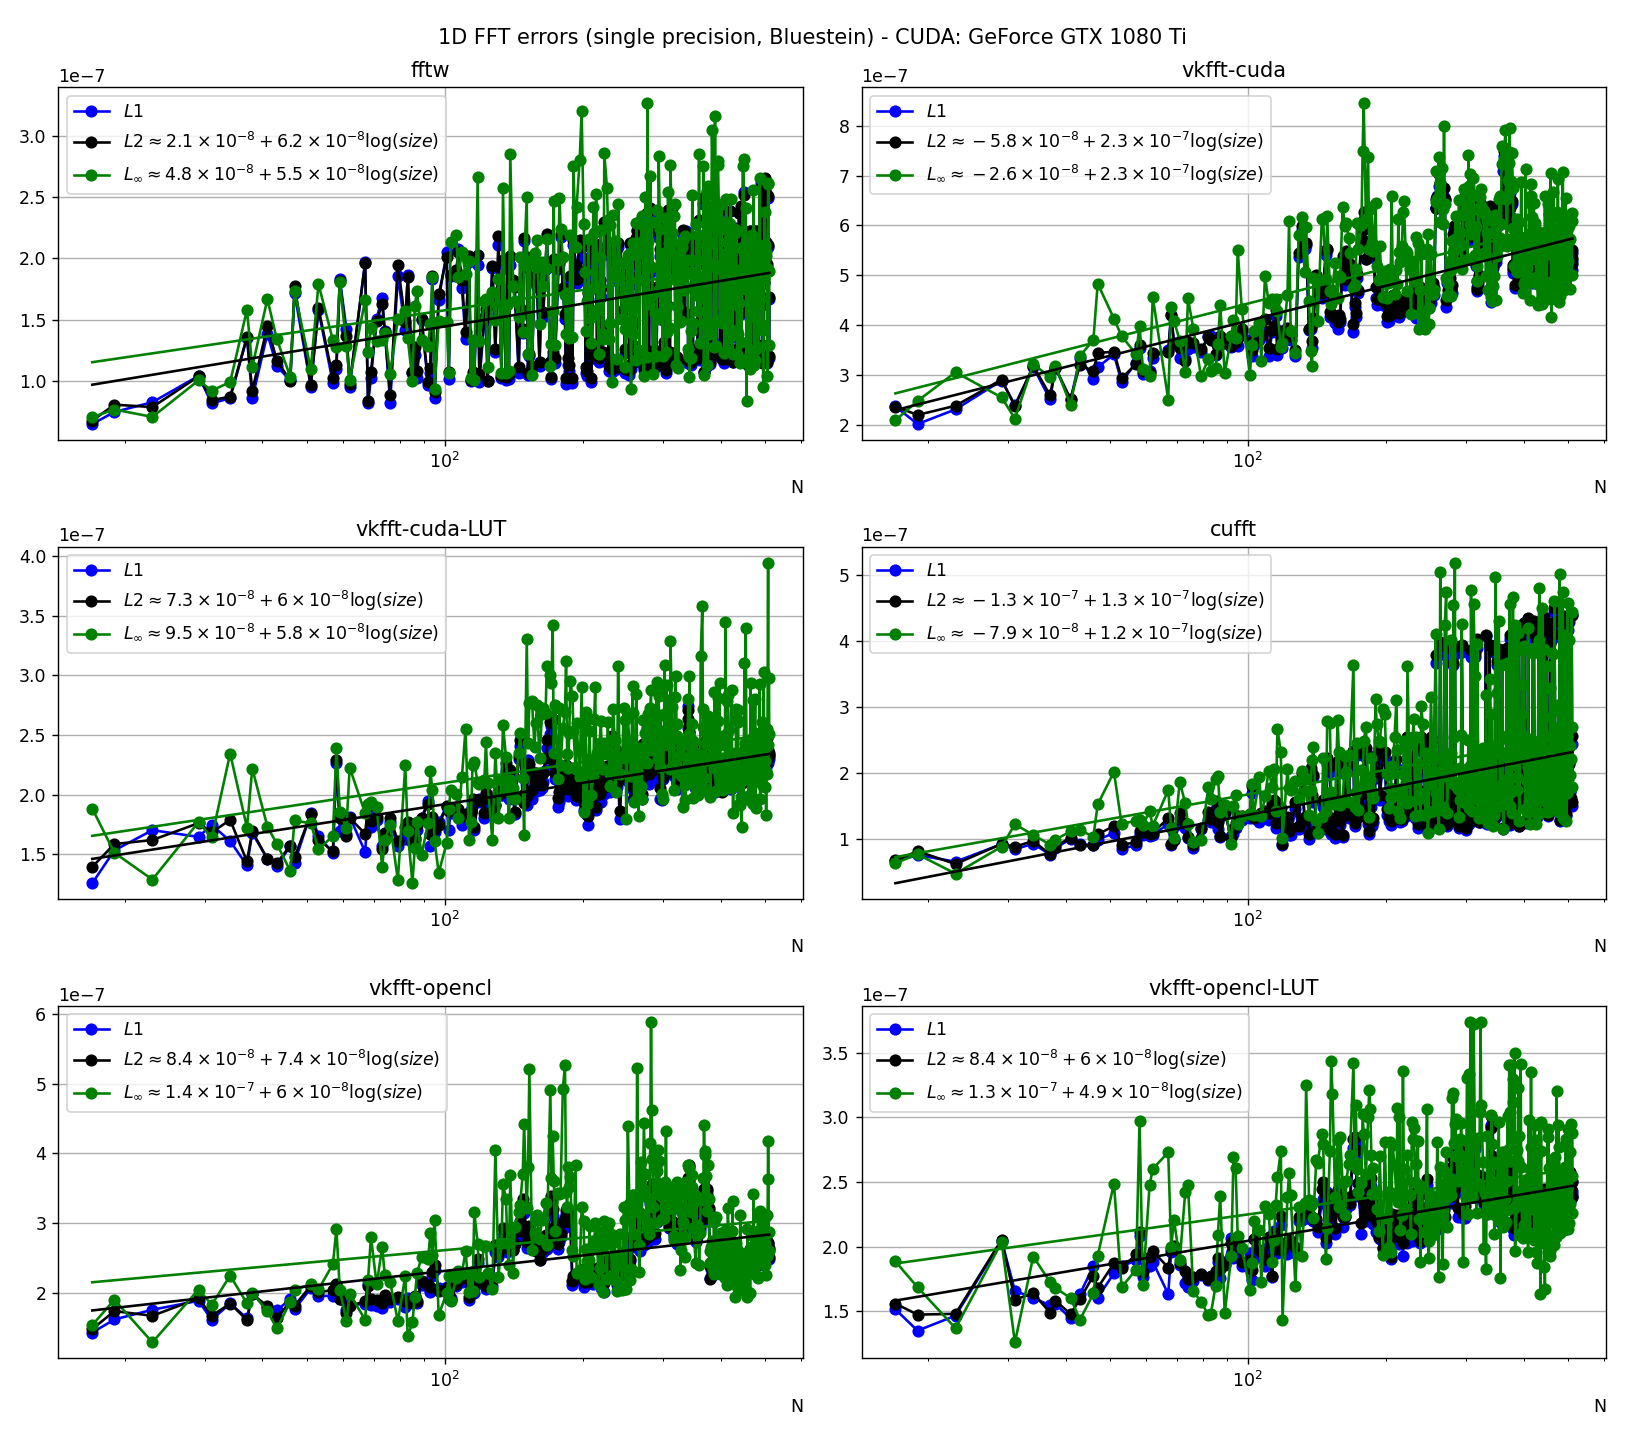

<IPython.core.display.Javascript object>


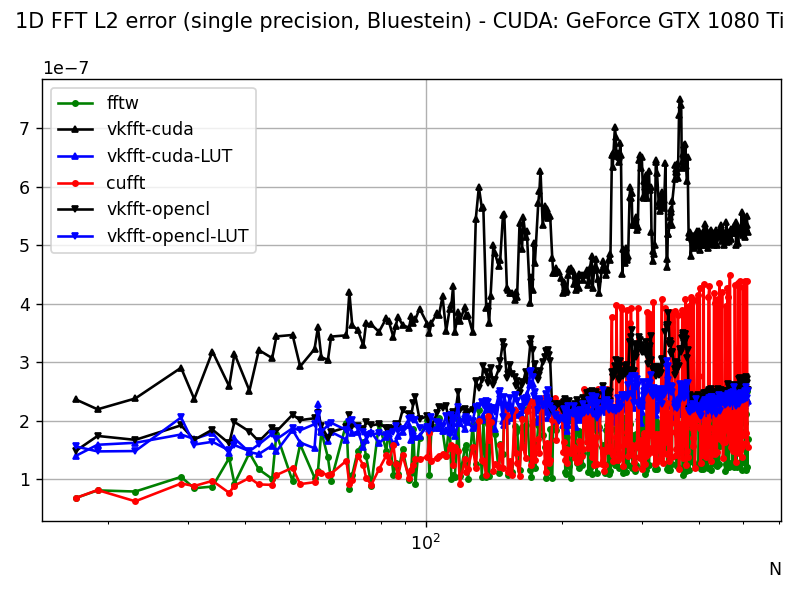

In [13]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("1D FFT errors (single precision, Bluestein) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("1D FFT L2 error (single precision, Bluestein) - " + device_name)
plt.grid(True)
plt.xlabel("N", loc='right')
plt.tight_layout()



# 1D, non-radix (Bluestein) transforms, double precision


In [14]:
nmax = 512
d0 = np.random.uniform(-0.5, 0.5, nmax) + 1j * np.random.uniform(-0.5, 0.5, nmax)
d0ld = d0.astype(np.clongdouble)
d0 = d0.astype(np.complex128)

def accu_1d(n, fft_dic):
    rld = fftwn(d0ld[:n])
    res = {}
    for k,v in fft_dic.items():
        r = v(d0[:n])
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res

fft_dic = {"fftw": fftwn}
if has_pycuda:
    fft_dic["vkfft-cuda"] = fftnvcu
    fft_dic["vkfft-cuda-LUT"] = fftnvculut
    fft_dic["cufft"] = fftncu
if has_pyopencl:
    fft_dic["vkfft-opencl"] = fftnvcl
    fft_dic["vkfft-opencl-LUT"] = fftnvcllut


# print(accu_1d(16, fft_dic))

vn, vl1, vl2, vli = [], {}, {}, {}

#print("%7s  %12s  %12s  %12s  %12s"%("N", "vkfft   ", "vkfft-LUT    ", "cufft   ", "fftw   "))
s = "%7s  %16s"%("N", "fftw   ")
r = accu_1d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %16s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) >13:  # test only transforms with non-radix dimensions
        r = accu_1d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        s = "%7d  %16e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N           fftw           vkfft-cuda    vkfft-cuda-LUT      vkfft-opencl  vkfft-opencl-LUT             cufft
     17      1.152418e-16      4.100973e-16      4.100973e-16      4.019577e-16      4.019577e-16      1.144480e-16
     19      1.943078e-16      4.341398e-16      4.341398e-16      4.618303e-16      4.618303e-16      1.595062e-16
     23      1.377567e-16      4.664383e-16      4.664383e-16      4.739990e-16      4.739990e-16      1.261504e-16
     29      1.515821e-16      5.889523e-16      5.889523e-16      5.618188e-16      5.618188e-16      1.973031e-16
     31      1.616343e-16      4.755829e-16      4.755829e-16      4.892842e-16      4.892842e-16      1.408040e-16
     34      1.494327e-16      5.814201e-16      5.814201e-16      5.244652e-16      5.244652e-16      1.272365e-16
     37      3.671868e-16      6.124134e-16      6.124134e-16      6.117037e-16      6.117037e-16      1.844281e-16
     38      1.641489e-16      5.833857e-16      5.833857e-16      5.802

    103      3.921759e-16      6.319480e-16      6.319480e-16      6.482670e-16      6.482670e-16      2.516292e-16
    106      4.228607e-16      6.996962e-16      6.996962e-16      7.211422e-16      7.211422e-16      2.037659e-16
    107      4.211683e-16      6.619910e-16      6.619910e-16      6.523139e-16      6.523139e-16      2.710273e-16
    109      3.822554e-16      6.355377e-16      6.355377e-16      6.714590e-16      6.714590e-16      2.585955e-16
    111      3.038160e-16      7.030638e-16      7.030638e-16      6.832234e-16      6.832234e-16      1.922650e-16
    113      4.261999e-16      6.525844e-16      6.525844e-16      6.511996e-16      6.511996e-16      2.753946e-16
    114      1.990482e-16      6.518085e-16      6.518085e-16      6.513144e-16      6.513144e-16      2.507053e-16
    115      2.041813e-16      6.506958e-16      6.506958e-16      6.462700e-16      6.462700e-16      1.817999e-16
    116      1.863426e-16      6.154763e-16      6.154763e-16      6.160

    167      3.965643e-16      1.428426e-15      1.428426e-15      1.464342e-15      1.464342e-15      4.327618e-14
    170      2.103905e-16      9.911071e-16      9.911071e-16      9.855028e-16      9.855028e-16      2.204799e-16
    171      2.055173e-16      1.186886e-15      1.186886e-15      1.139132e-15      1.139132e-15      2.497387e-16
    172      1.967420e-16      1.067804e-15      1.067804e-15      1.073716e-15      1.073716e-15      2.218554e-16
    173      4.192220e-16      1.390141e-15      1.390141e-15      1.417206e-15      1.417206e-15      1.501237e-14
    174      2.230696e-16      1.367624e-15      1.367624e-15      1.401596e-15      1.401596e-15      2.711243e-16
    177      4.119804e-16      1.079094e-15      1.079094e-15      1.090201e-15      1.090201e-15      2.235539e-16
    178      4.071486e-16      1.139018e-15      1.139018e-15      1.129687e-15      1.129687e-15      2.683084e-16
    179      4.002496e-16      1.132634e-15      1.132634e-15      1.054

    223      4.387874e-16      6.608253e-16      6.608253e-16      6.680330e-16      6.680330e-16      3.513117e-14
    226      4.391770e-16      6.991922e-16      6.991922e-16      7.016479e-16      7.016479e-16      2.614784e-16
    227      4.211505e-16      6.660238e-16      6.660238e-16      6.305548e-16      6.305548e-16      2.263896e-14
    228      2.007461e-16      6.538246e-16      6.538246e-16      6.265656e-16      6.265656e-16      2.508290e-16
    229      3.935671e-16      7.109566e-16      7.109566e-16      7.198530e-16      7.198530e-16      2.538205e-14
    230      2.156442e-16      6.042618e-16      6.042618e-16      6.480364e-16      6.480364e-16      1.974817e-16
    232      1.923604e-16      7.466031e-16      7.466031e-16      7.510657e-16      7.510657e-16      2.007747e-16
    233      4.020842e-16      7.093054e-16      7.093054e-16      7.220764e-16      7.220764e-16      2.549879e-14
    235      3.935051e-16      6.596056e-16      6.596056e-16      6.857

    279      2.334356e-16      2.580519e-15      2.580519e-15      2.659111e-15      2.659111e-15      2.278091e-16
    281      4.231052e-16      1.655825e-15      1.655825e-15      1.671147e-15      1.671147e-15      5.115777e-14
    282      3.680533e-16      1.640278e-15      1.640278e-15      1.680061e-15      1.680061e-15      2.651793e-16
    283      4.520019e-16      1.702950e-15      1.702950e-15      1.700858e-15      1.700858e-15      4.147434e-14
    284      4.092422e-16      1.661998e-15      1.661998e-15      1.637787e-15      1.637787e-15      2.414881e-16
    285      2.205772e-16      1.130738e-15      1.130738e-15      1.141854e-15      1.141854e-15      2.705828e-16
    287      3.465358e-16      1.119004e-15      1.119004e-15      1.111583e-15      1.111583e-15      2.370000e-16
    289      2.146891e-16      2.318164e-15      2.318164e-15      2.304065e-15      2.304065e-15      2.750333e-16
    290      2.301387e-16      2.410413e-15      2.410413e-15      2.390

    332      3.811131e-16      1.467722e-15      1.467722e-15      1.483314e-15      1.483314e-15      2.698698e-16
    333      3.485723e-16      1.539064e-15      1.539064e-15      1.540301e-15      1.540301e-15      2.999202e-16
    334      3.958140e-16      1.534240e-15      1.534240e-15      1.532780e-15      1.532780e-15      5.436603e-16
    335      3.777984e-16      1.482574e-15      1.482574e-15      1.509469e-15      1.509469e-15      2.439032e-16
    337      4.796452e-16      1.243783e-15      1.243783e-15      1.299753e-15      1.299753e-15      3.980197e-14
    339      4.390009e-16      2.896104e-15      2.896104e-15      2.881495e-15      2.881495e-15      3.370863e-16
    340      2.236938e-16      2.856495e-15      2.856495e-15      2.901996e-15      2.901996e-15      2.997139e-16
    341      2.202748e-16      2.872012e-15      2.872012e-15      2.848150e-15      2.848150e-15      2.159638e-16
    342      2.239133e-16      2.838807e-15      2.838807e-15      2.836

    383      4.366467e-16      6.987595e-16      6.987595e-16      6.802236e-16      6.802236e-16      7.814903e-14
    386      3.775412e-16      6.647902e-16      6.647902e-16      6.718855e-16      6.718855e-16      5.816232e-16
    387      2.465475e-16      6.585150e-16      6.585150e-16      6.515906e-16      6.515906e-16      2.875136e-16
    388      3.326757e-16      6.878727e-16      6.878727e-16      6.964512e-16      6.964512e-16      2.839728e-16
    389      4.753219e-16      7.042651e-16      7.042651e-16      6.925251e-16      6.925251e-16      6.258627e-14
    391      2.265986e-16      6.964603e-16      6.964603e-16      7.161221e-16      7.161221e-16      2.319438e-16
    393      4.437033e-16      7.047365e-16      7.047365e-16      7.038950e-16      7.038950e-16      6.052462e-16
    394      3.917027e-16      6.848681e-16      6.848681e-16      7.022259e-16      7.022259e-16      5.460024e-16
    395      3.843953e-16      6.925702e-16      6.925702e-16      7.183

    434      2.402958e-16      7.490997e-16      7.490997e-16      7.351306e-16      7.351306e-16      2.887393e-16
    435      2.369226e-16      7.098072e-16      7.098072e-16      6.917903e-16      6.917903e-16      3.721807e-16
    436      4.017288e-16      6.990213e-16      6.990213e-16      6.971213e-16      6.971213e-16      2.953540e-16
    437      2.331481e-16      6.916194e-16      6.916194e-16      7.034986e-16      7.034986e-16      2.183560e-16
    438      3.632866e-16      6.799459e-16      6.799459e-16      7.003220e-16      7.003220e-16      2.680413e-16
    439      4.664556e-16      6.684107e-16      6.684107e-16      6.842777e-16      6.842777e-16      4.792099e-14
    442      2.429533e-16      7.137712e-16      7.137712e-16      7.076939e-16      7.076939e-16      3.091112e-16
    443      4.588270e-16      6.805042e-16      6.805042e-16      6.984341e-16      6.984341e-16      4.611611e-14
    444      3.387085e-16      7.150379e-16      7.150379e-16      7.569

    482      3.824167e-16      7.076884e-16      7.076884e-16      7.314313e-16      7.314313e-16      5.884894e-16
    483      2.270259e-16      7.559921e-16      7.559921e-16      7.725469e-16      7.725469e-16      3.126539e-16
    485      3.624383e-16      7.207185e-16      7.207185e-16      7.236376e-16      7.236376e-16      3.106790e-16
    487      4.433044e-16      7.216372e-16      7.216372e-16      7.254905e-16      7.254905e-16      1.120706e-13
    488      2.995088e-16      7.307366e-16      7.307366e-16      7.484853e-16      7.484853e-16      2.970293e-16
    489      4.664281e-16      7.051023e-16      7.051023e-16      7.249765e-16      7.249765e-16      5.804102e-16
    491      4.869181e-16      6.921088e-16      6.921088e-16      6.971921e-16      6.971921e-16      4.881863e-14
    492      3.494194e-16      7.131179e-16      7.131179e-16      7.332613e-16      7.332613e-16      3.426297e-16
    493      2.243584e-16      7.096370e-16      7.096370e-16      7.280

<IPython.core.display.Javascript object>


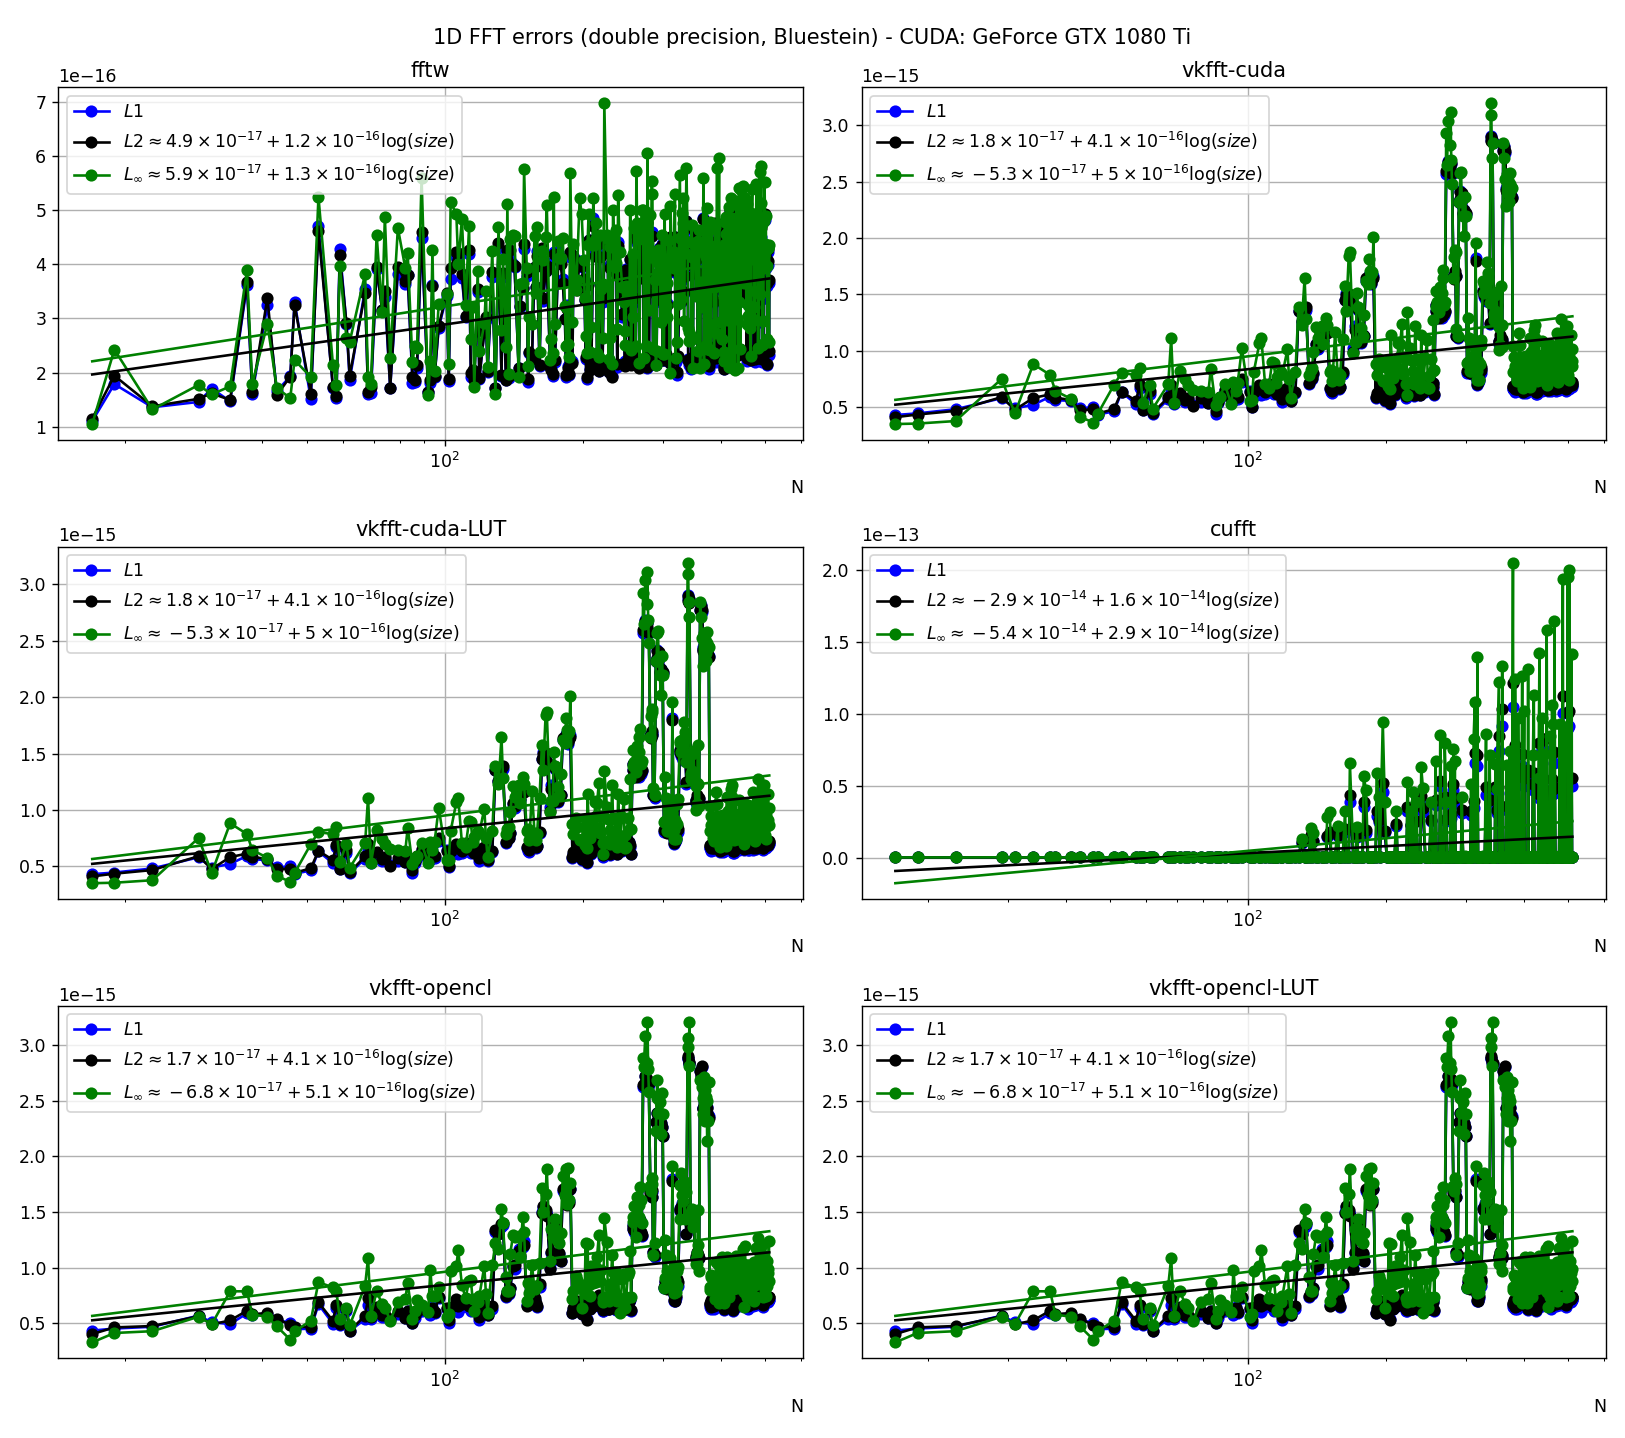

<IPython.core.display.Javascript object>


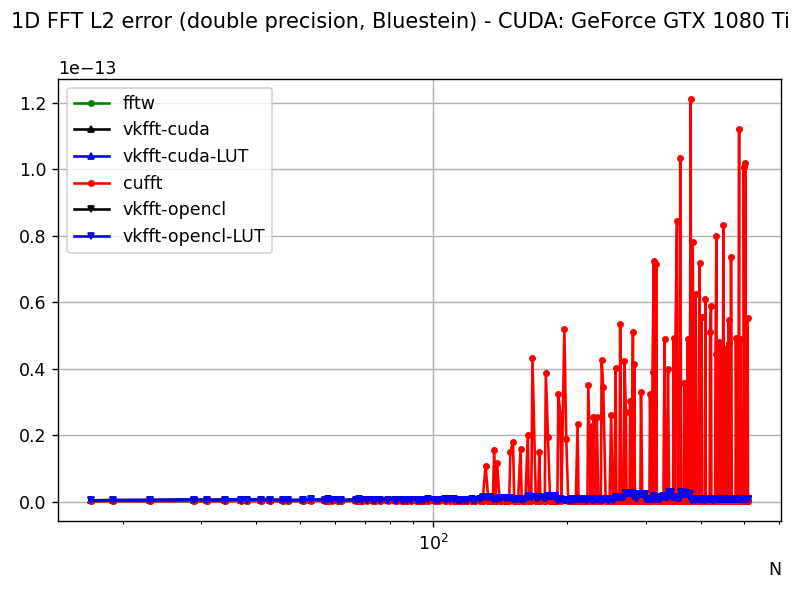

In [15]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("1D FFT errors (double precision, Bluestein) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("1D FFT L2 error (double precision, Bluestein) - " + device_name)
plt.grid(True)
plt.xlabel("N", loc='right')
plt.tight_layout()



# 2D, non-radix (Bluestein) transforms, single precision

In [16]:
nmax = 101
d0 = np.random.uniform(-0.5, 0.5, (nmax, nmax)) + 1j * np.random.uniform(-0.5, 0.5, (nmax, nmax))
d0ld = d0.astype(np.clongdouble)
d0s = d0.astype(np.complex64)

def accu_2d(n, fft_dic):
    rld = fftwn(d0ld[:n,:n].copy())
    res = {}
    for k,v in fft_dic.items():
        r = v(d0s[:n,:n].copy())
        res[k] = l1(rld, r),l2(rld, r),li(rld, r)
    return res

fft_dic = {"fftw": fftwn}
if has_pycuda:
    fft_dic["vkfft-cuda"] = fftnvcu
    fft_dic["vkfft-cuda-LUT"] = fftnvculut
    fft_dic["cufft"] = fftncu
if has_pyopencl:
    fft_dic["vkfft-opencl"] = fftnvcl
    fft_dic["vkfft-opencl-LUT"] = fftnvcllut


# print(accu_1d(16, fft_dic))

vn, vl1, vl2, vli = [], {}, {}, {}

#print("%7s  %12s  %12s  %12s  %12s"%("N", "vkfft   ", "vkfft-LUT    ", "cufft   ", "fftw   "))
s = "%7s  %16s"%("N", "fftw   ")
r = accu_2d(8, fft_dic)
for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
    if k in r:
        s += "  %16s" % k
print(s)
for n in range(8, len(d0)+1):
    if max(primes(n)) >13:  # test only transforms with non-radix dimensions
        r = accu_2d(n, fft_dic)
        vn.append(n)
        for k, v in r.items():
            if k not in vl1:
                vl1[k] = []
                vl2[k] = []
                vli[k] = []
            vl1[k].append(v[0])
            vl2[k].append(v[1])
            vli[k].append(v[2])
        s = "%7d  %16e" % (n, vl2["fftw"][-1])
        for k in ["vkfft-cuda", "vkfft-cuda-LUT", "vkfft-opencl", "vkfft-opencl-LUT", "cufft"]:
            if k in vl2:
                red = int(np.log10(vl2[k][-1] / vl2["fftw"][-1]) / np.log10(100) * 255)
                if red < 0:
                    red = 0
                if red > 255:
                    red = 255
                s += "\x1b[38;2;%d;0;0m    %14e\x1b[0m" % (red, vl2[k][-1])
        print(s)


      N           fftw           vkfft-cuda    vkfft-cuda-LUT      vkfft-opencl  vkfft-opencl-LUT             cufft
     17      1.057807e-07      4.000992e-07      2.395381e-07      2.337372e-07      2.368279e-07      9.764867e-08
     19      1.091140e-07      4.376637e-07      2.726232e-07      2.683255e-07      2.813029e-07      1.034432e-07
     23      1.194018e-07      4.063653e-07      2.495411e-07      2.623447e-07      2.759498e-07      1.108334e-07
     29      1.295736e-07      4.492496e-07      2.881181e-07      3.166111e-07      3.157936e-07      1.195725e-07
     31      1.314515e-07      3.984253e-07      2.350446e-07      2.701490e-07      2.681874e-07      1.218273e-07
     34      1.312034e-07      5.760906e-07      2.993704e-07      2.862034e-07      3.037275e-07      1.255890e-07
     37      1.912260e-07      5.050688e-07      2.442175e-07      2.573486e-07      2.646907e-07      1.304238e-07
     38      1.242259e-07      5.441883e-07      2.675598e-07      2.576

<IPython.core.display.Javascript object>


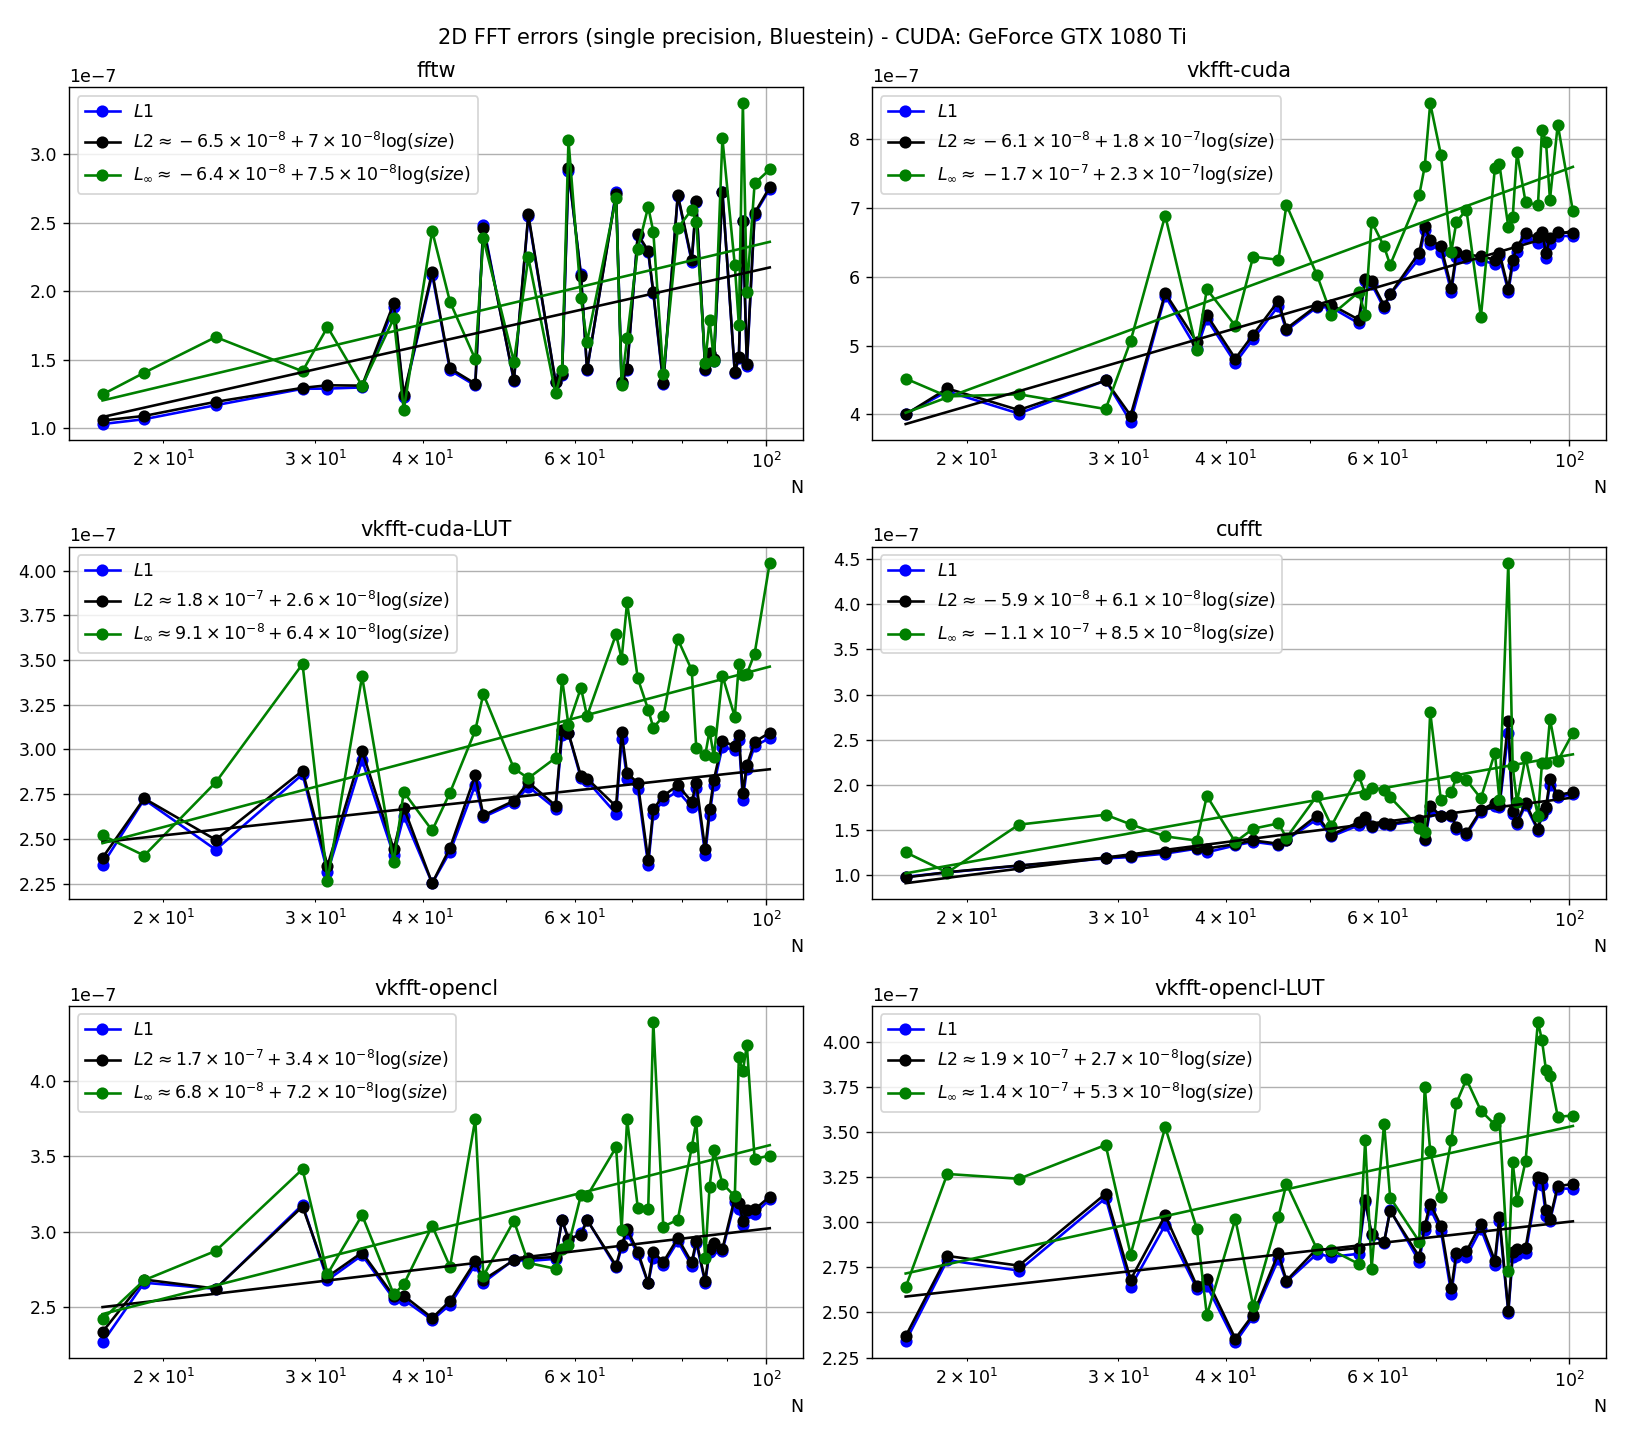

<IPython.core.display.Javascript object>


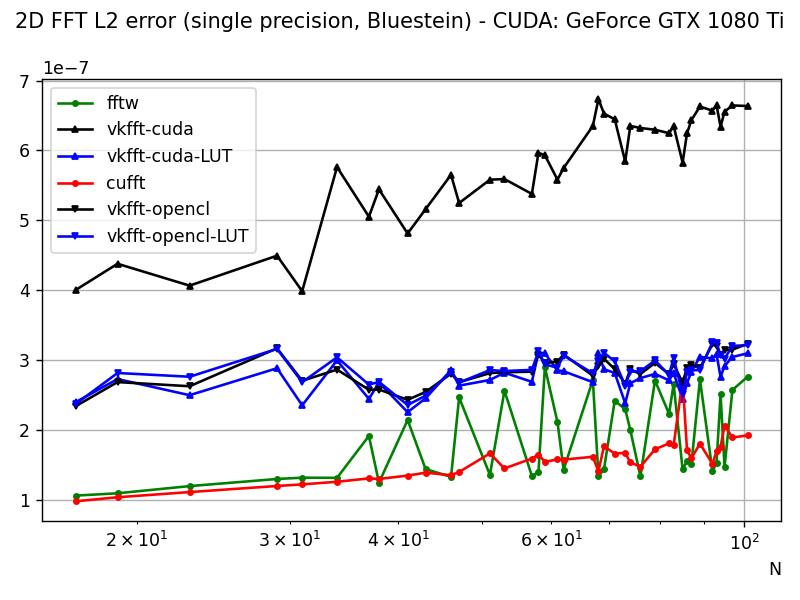

In [17]:
plt.figure(figsize=(13,1+(len(vl2)+1)*1.5))
vk = vl2.keys()

x = np.array(vn, dtype=np.float32)
xl = d0.ndim * np.log10(x)  # Use the size of the array

i=1
for k in vk:
    plt.subplot((len(vl2)+1)//2,2,i)
    plt.semilogx(vn, vl1[k], '-ob', label="$L1$")

    r2 = stats.linregress(xl, np.array(vl2[k], dtype=np.float32))
    plt.semilogx(vn, vl2[k], '-ok', label=r"$L2\approx %s+%s\log(size)$" % (latex_float(r2[1]), latex_float(r2[0])))

    ri = stats.linregress(xl, np.array(vli[k], dtype=np.float32))
    plt.semilogx(vn, vli[k], '-og', label=r"$L_{\infty}\approx %s+%s\log(size)$" % (latex_float(ri[1]), latex_float(ri[0])))

    plt.semilogx(x, r2[1] + r2[0]*xl, "k-")
    plt.semilogx(x, ri[1] + ri[0]*xl, "g-")
    plt.title(k)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.xlabel("N", loc='right')
    i+=1


plt.suptitle("2D FFT errors (single precision, Bluestein) - " + device_name)

plt.tight_layout()

plt.figure()
ms = 3

clrs = {"fftw":'-og', "vkfft-cuda": "-^k", "vkfft-cuda-LUT":"-^b", "vkfft-opencl": "-vk", "vkfft-opencl-LUT":"-vb","cufft":"-or"}

for k,v in vl2.items():
    plt.semilogx(vn, v, clrs[k], markersize=ms, label=k)
plt.legend(loc='upper left')
plt.suptitle("2D FFT L2 error (single precision, Bluestein) - " + device_name)
plt.grid(True)
plt.xlabel("N", loc='right')
plt.tight_layout()

